# Demo de Deep Convolutional Inverse Graphics Network (DCIGN) para colorear las imágenes de algunos TIPOS de ANIMALES


1) Importar librerías:

In [1]:
#@title Librerías a usar
import tensorflow.keras
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.layers import Reshape, Flatten
from tensorflow.keras.layers import UpSampling2D, Conv2DTranspose, BatchNormalization
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model

from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import os

from PIL import Image

print("\nLibrerías importadas")


Librerías importadas


2) Definir la configuración del modelo DCIGN:

In [2]:
## selección de los parámetros 

#@markdown ### Parámetros de imágenes:
imagen_largo_ancho =  64#@param {type:"integer"}

#@markdown ### Parámetros de la red:
dae_tamaño_kernel = 5 #@param {type:"integer"}
dae_tamaño_pooling = 2 #@param {type:"integer"}
dae_cantidad_capas_ocultas = 3 #@param {type:"integer"}
dae_tipo_capas = 'LeakyReLU' #@param [ 'Conv2D + UpSampling', 'Conv2DTranspose + BatchNormalization', 'LeakyReLU']

dae_cant_epocas_entrenamiento = 500 #@param {type:"integer"}

## aplicación de los parámetros elegidos

# tamaño de las imágenes
if imagen_largo_ancho<=10:
  imagen_largo_ancho = 10
IMAGE_SHAPE = (imagen_largo_ancho, imagen_largo_ancho, 3)

# indica si se usan las imágenes generadas por data augmentation
usarDA = False

# tamaño de los kernels y pooling (para simplificar son todas iguales)
if dae_tamaño_kernel<1:
  dae_tamaño_kernel = 1
dae_kernel_shape = (dae_tamaño_kernel, dae_tamaño_kernel)
if dae_tamaño_pooling<1:
  dae_tamaño_pooling=1
dae_pooling_shape = (dae_tamaño_pooling, dae_tamaño_pooling)

# indica la configuración para la parte Encoder 
#   (cada elemento de las listas son la configuración de las capas Conv)
if dae_cantidad_capas_ocultas<1:
  dae_cantidad_capas_ocultas = 1
dae_filters = []
for i in range(dae_cantidad_capas_ocultas, 0, -1):
  dae_filters.append( 2**(i+2) )

# la capa de features se define automáticamente 
# en base a la información de la última capa del Encoder
dae_filters.append( 'f' ) 
dae_posLayFeat = len(dae_filters)-1

# cantidad de neuronas ocultas para la parte Decoder 
#   (usa la la lista de Encoder inversa)
for eachEncFilter in dae_filters[0:len(dae_filters)-1][::-1]:
      dae_filters.append( eachEncFilter )


# indica si el Decoder usa:
#  ver 1: Conv2D + UpSampling (mejores colores pero fuera de foco)
#  ver 2: Conv2DTranspose + BatchNormalization (mejor nitidez pero como manchada)
if dae_tipo_capas == 'Conv2D + UpSampling':
  verCapasDecoder = 1
elif dae_tipo_capas == 'LeakyReLU':
  verCapasDecoder = 3
else:
  verCapasDecoder = 2

# cantidad de épocas del entrenamiento
cantEpocas = (100 if dae_cant_epocas_entrenamiento<1 else dae_cant_epocas_entrenamiento)

print("Configuración del DAE CNN definida: ")
print ("     -Kernels + Pooling: [", IMAGE_SHAPE, "[", dae_kernel_shape, "+", dae_pooling_shape, "]", IMAGE_SHAPE, "] ")
print ("     -Versión Decoder: ", dae_tipo_capas, "(", verCapasDecoder,  ") ")
print ("     -Cant. de Filters: [ -,", dae_filters,  ",- ] ")

Configuración del DAE CNN definida: 
     -Kernels + Pooling: [ (64, 64, 3) [ (5, 5) + (2, 2) ] (64, 64, 3) ] 
     -Versión Decoder:  LeakyReLU ( 3 ) 
     -Cant. de Filters: [ -, [32, 16, 8, 'f', 8, 16, 32] ,- ] 


3) Montar el Drive:

In [3]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

# directorio local en Google Drive
path = 'gdrive/My Drive/IA/demo ANIMALES/imagenes' #@param {type:"string"}
path_entrenamiento = '/train'  #@param {type:"string"}
path_prueba = '/test'  #@param {type:"string"}

imagPath_train = path + path_entrenamiento
imagPath_test = path + path_prueba

Mounted at /content/gdrive


4) Cargar imágenes para entrenar el modelo DAE:

> Para Entrenamiento: 
- Clases cargadas:  102
- Imágenes cargadas:  102
- Ejemplo  reptil   (64, 64, 3)   (64, 64, 3) : 


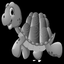

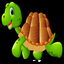



> Para Prueba: 
- Clases cargadas:  60
- Imágenes cargadas:  60
- Ejemplo  reptil   (64, 64, 3)   (64, 64, 3) : 


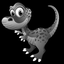

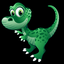

In [4]:
#@title Cargar Imágenes (de entrada en blanco y negro, y de salida en color)
# define función para cargar las imágenes
def cargarImagenes(imagPath):
  classes_ori = [] 
  images_ori = []
  esDA_ori = []
  images_sal = []

  all_dirs = os.listdir( imagPath )
  for each_dir in all_dirs:

      auxiPath = imagPath + '/' + each_dir 
      imagFN  = os.listdir( auxiPath )
      for each_imagFN in imagFN:

            esImagDA = (each_imagFN[:2] == 'da')
                  
            # abre la imagen
            imag = Image.open(auxiPath + "/" + each_imagFN)
            
            # ajusta el tamaño     
            tipoImage = 'RGB'
            imag = imag.convert('RGB')
            imag = imag.resize((IMAGE_SHAPE[0], IMAGE_SHAPE[1]), Image.ANTIALIAS)          
            
            imag2 = imag.convert('L')
            imag2 = imag2.convert('RGB')

            # transforma a un vector de nros
            arImag = np.array(imag)
            arImag2 = np.array(imag2)
            
            # agrega a los vectores
            classes_ori.append( each_dir )
            images_ori.append( arImag2 )
            images_sal.append( arImag )
            esDA_ori.append( esImagDA )

  return classes_ori, images_ori, images_sal, esDA_ori, tipoImage

# carga las imagenes de entrenamiento
classes_train, images_train_x, images_train_y, esDAimag_train, tipoImage_train = cargarImagenes(imagPath_train)
print("> Para Entrenamiento: ")
print("- Clases cargadas: ", len(classes_train))
print("- Imágenes cargadas: ", len(images_train_x))

if len(classes_train)>0:
  print("- Ejemplo ", classes_train[0], " ", images_train_x[0].shape, " ", images_train_y[0].shape,  ": ")
  display( Image.fromarray(images_train_x[0], tipoImage_train) )
  display( Image.fromarray(images_train_y[0], tipoImage_train) )

# carga las imagenes de prueba
classes_test, images_test_x, images_test_y, esDAimag_test, tipoImage_test = cargarImagenes(imagPath_test)
print("\n\n> Para Prueba: ")
print("- Clases cargadas: ", len(classes_test))
print("- Imágenes cargadas: ", len(images_test_x))

if len(classes_test)>0:
  print("- Ejemplo ", classes_test[0], " ", images_test_x[0].shape, " ", images_test_y[0].shape, ": ")
  display( Image.fromarray(images_test_x[0], tipoImage_test) )
  display( Image.fromarray(images_test_y[0], tipoImage_test) )

> Para Entrenamiento: 
 - x_train (cant ejemplos, datos entrada):  (102, 64, 64, 3)
 - y_train (cant ejemplos, datos entrada):  (102, 64, 64, 3)


> Para Prueba: 
 - x_test (cant ejemplos, datos entrada):  (60, 64, 64, 3)
 - y_test (cant ejemplos, datos entrada):  (60, 64, 64, 3)


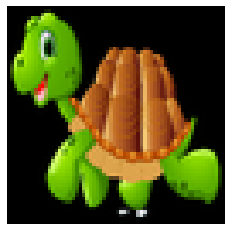

In [5]:
#@title Preparar imágenes

# define función auxiliar para mostrar imágenes preparadas
def plot_image(imag):
  if IMAGE_SHAPE[2]==1:
    plt.imshow((imag*255).reshape(IMAGE_SHAPE[0], IMAGE_SHAPE[1]).astype(np.uint8))
    plt.gray()  
  else:
    plt.imshow((imag*255).reshape(IMAGE_SHAPE).astype(np.uint8)) 
  plt.axis("off")  

# define función auxiliar para preparar la lista de imágenes a procesar
def prepare_imageList(imagList):    
  auxiAr = np.array(imagList).astype('float32') / 255.
  auxiAr = auxiAr.reshape((len(auxiAr), IMAGE_SHAPE[0], IMAGE_SHAPE[1], IMAGE_SHAPE[2]))  
  return auxiAr
  
# define vector auxiliar de datos de entrada para usar en el entrenamiento y prueba
x_train = prepare_imageList(images_train_x)
y_train = prepare_imageList(images_train_y)
x_test = prepare_imageList(images_test_x)
y_test = prepare_imageList(images_test_y)

print("> Para Entrenamiento: ")
print(" - x_train (cant ejemplos, datos entrada): ", x_train.shape)
print(" - y_train (cant ejemplos, datos entrada): ", y_train.shape)
print("\n\n> Para Prueba: ")
print(" - x_test (cant ejemplos, datos entrada): ", x_test.shape)
print(" - y_test (cant ejemplos, datos entrada): ", y_test.shape)
if len(x_train)>0:
  plot_image(x_train[0])
  plot_image(y_train[0])

5) Creación del modelo DCIGN:

Modelo DAE CNN creado con  23  capas:
Model: "DCIGNmodel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_img (InputLayer)       [(None, 64, 64, 3)]       0         
_________________________________________________________________
c_enc_1 (Conv2D)             (None, 64, 64, 32)        2432      
_________________________________________________________________
cl_enc_1 (LeakyReLU)         (None, 64, 64, 32)        0         
_________________________________________________________________
p_enc_1 (MaxPooling2D)       (None, 32, 32, 32)        0         
_________________________________________________________________
c_enc_2 (Conv2D)             (None, 32, 32, 16)        12816     
_________________________________________________________________
cl_enc_2 (LeakyReLU)         (None, 32, 32, 16)        0         
_________________________________________________________________
p_enc_2 (MaxPoolin

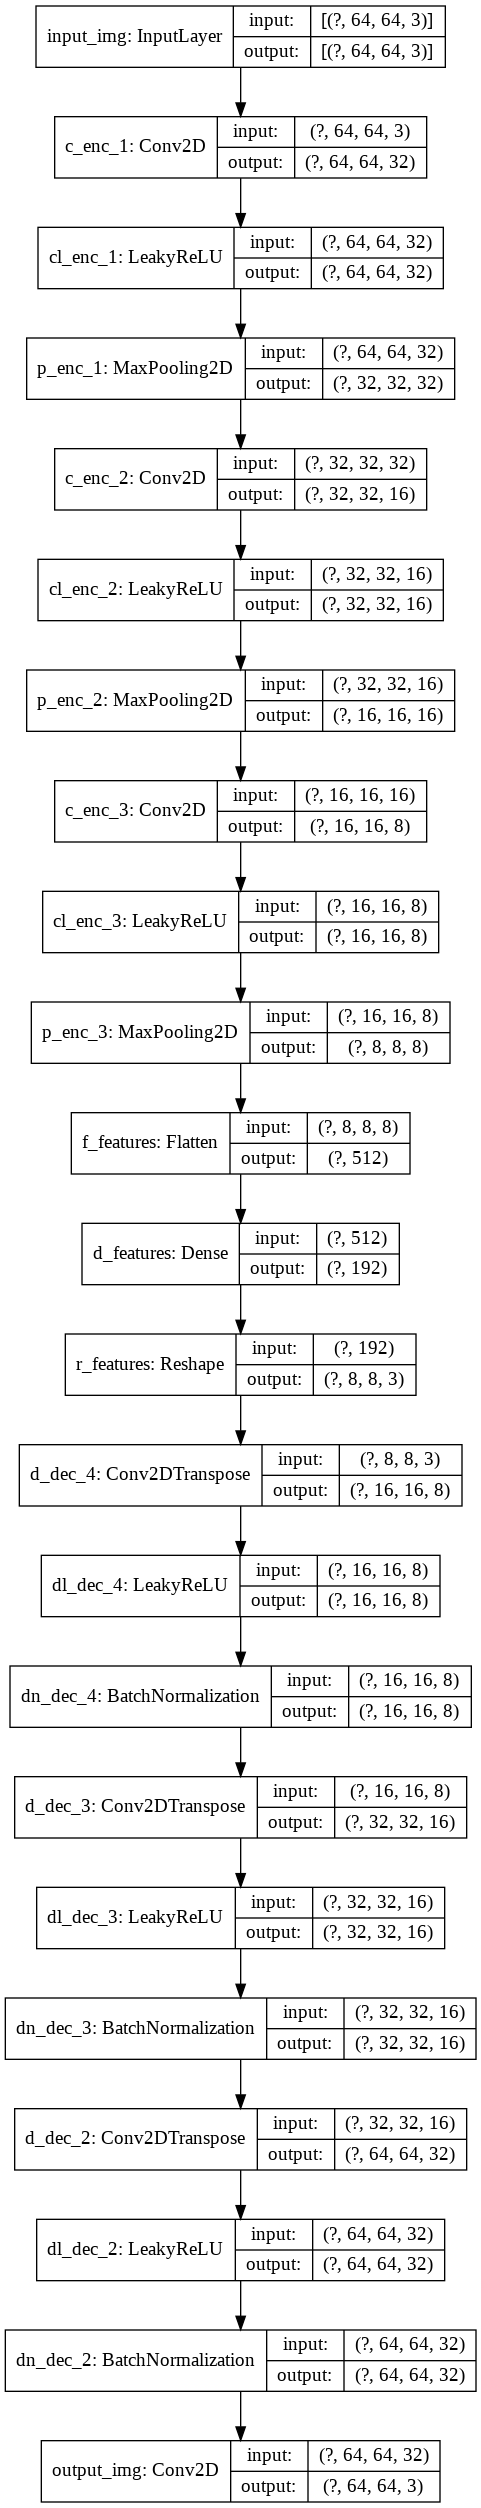

In [6]:
#@title Establecer modelo

# define la arquitectura de capas del Deep Autoencoder CNN
# teniendo en cuenta la definición dada anteriomente
input_img_Lay = Input(shape=IMAGE_SHAPE, name='input_img') # capa de entrada
eachLay = input_img_Lay
auxName = 'enc_'
auxId = 1 
for i in range(len(dae_filters)):  

    # define el nombre de la capa oculta
    auxlayerName = auxName+str(auxId)
    if i==dae_posLayFeat:
        auxlayerName = 'features'
        auxName = 'dec_'        
    else:        
        if auxName == 'enc_':
          auxId = auxId + 1
        else:
          auxId = auxId - 1

    # agrega las capas ocultas
    if auxlayerName.startswith('enc_'):
        if verCapasDecoder == 3:
          # agrega capa Conv2D + LeakyReLU para Encoder
          eachLay = Conv2D(dae_filters[i], dae_kernel_shape, padding='same', name='c_'+auxlayerName)(eachLay) 
          eachLay = LeakyReLU(alpha=0.2, name='cl_'+auxlayerName)(eachLay) 
        else:
          # agrega capa Conv2D para Encoder
          eachLay = Conv2D(dae_filters[i], dae_kernel_shape, activation='relu', padding='same', name='c_'+auxlayerName)(eachLay) 
        # agrega capa MaxPooling para Encoder
        eachLay = MaxPooling2D(dae_pooling_shape, padding='same', name='p_'+auxlayerName)(eachLay)

    elif auxlayerName.startswith('dec_'):
      if verCapasDecoder == 2:
          # Dec v2: agrega capa Conv2DTranspose con BatchNormalization para Decoder        
          eachLay = Conv2DTranspose(dae_filters[i], dae_kernel_shape, strides=2, activation='relu', padding='same', name='d_'+auxlayerName)(eachLay) 
          eachLay = BatchNormalization(name='p_'+auxlayerName)(eachLay)
      elif verCapasDecoder == 3:
          # Dec v3: agrega capa Conv2DTranspose con LeakyReLU y BatchNormalization para Decoder                  
          eachLay = Conv2DTranspose(dae_filters[i], dae_kernel_shape, strides=2, padding='same', name='d_'+auxlayerName)(eachLay) 
          eachLay = LeakyReLU(alpha=0.2, name='dl_'+auxlayerName)(eachLay) 
          eachLay = BatchNormalization(axis=-1, name='dn_'+auxlayerName)(eachLay)
      else: 
          # Dec v1: agrega capa Conv2 + UpSampling2D para Decoder        
          eachLay = Conv2D(dae_filters[i], dae_kernel_shape, activation='relu', padding='same', name='d_'+auxlayerName)(eachLay) 
          eachLay = UpSampling2D(dae_pooling_shape, name='p_'+auxlayerName)(eachLay)

    elif auxlayerName.startswith('features'):
          #  agrega capa Flatten, Dense y Reshape 
          # para ello utiliza la información del shape de la última capa Encoder
          # y la cantidad de canales de la imagen original
          dae_features_shape = (int(eachLay.shape[1]), int(eachLay.shape[2]), IMAGE_SHAPE[2])
          num_features = dae_features_shape[0]*dae_features_shape[1]*dae_features_shape[2]      

          eachLay = Flatten(name='f_'+auxlayerName)(eachLay)
          eachLay = Dense(num_features, activation='sigmoid', name='d_'+auxlayerName)(eachLay)
          features_Lay = eachLay
          eachLay = Reshape(dae_features_shape, name='r_'+auxlayerName)(eachLay)

# agrega la capa de salida usando la cantidad de canales de la imagen como cantidad de filtros   
output_img_Lay = Conv2D(IMAGE_SHAPE[2], dae_kernel_shape, activation='sigmoid', padding='same', name='output_img')(eachLay)  # capa de salida

# genera el modelo Deep Autoencoder
DCIGNmodel = Model(input_img_Lay, output_img_Lay, name='DCIGNmodel')
#DCIGNmodel.compile(optimizer='adam', loss='mse')
#DCIGNmodel.compile(optimizer='adam', loss='binary_crossentropy')
optAdam = Adam(lr=1e-3)
DCIGNmodel.compile(optimizer=optAdam, loss='mse')

print("Modelo DAE CNN creado con ", len(DCIGNmodel.layers), " capas:")
DCIGNmodel.summary()
print("\n")
plot_model(DCIGNmodel, show_layer_names=True, show_shapes=True)

5) Entrenar el modelo DAE:

In [7]:
#@title Entrenar

# lleva a cabo el entrenamiento
# usando los mismos datos como entrada y salida
history = DCIGNmodel.fit(x_train, y_train,
                epochs = cantEpocas,
                shuffle=True)

Epoch 1/500
4/4 [==============================] - 0s 77ms/step - loss: 0.2241
Epoch 2/500
4/4 [==============================] - 0s 26ms/step - loss: 0.1876
Epoch 3/500
4/4 [==============================] - 0s 26ms/step - loss: 0.1668
Epoch 4/500
4/4 [==============================] - 0s 25ms/step - loss: 0.1516
Epoch 5/500
4/4 [==============================] - 0s 26ms/step - loss: 0.1402
Epoch 6/500
4/4 [==============================] - 0s 25ms/step - loss: 0.1280
Epoch 7/500
4/4 [==============================] - 0s 26ms/step - loss: 0.1132
Epoch 8/500
4/4 [==============================] - 0s 25ms/step - loss: 0.1002
Epoch 9/500
4/4 [==============================] - 0s 26ms/step - loss: 0.0916
Epoch 10/500
4/4 [==============================] - 0s 26ms/step - loss: 0.0834
Epoch 11/500
4/4 [==============================] - 0s 24ms/step - loss: 0.0755
Epoch 12/500
4/4 [==============================] - 0s 25ms/step - loss: 0.0687
Epoch 13/500
4/4 [==============================]

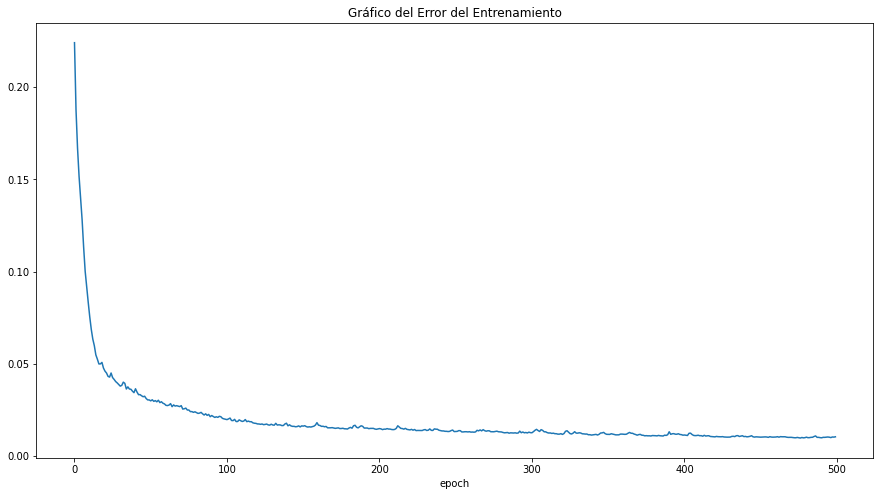

In [8]:
#@title Mostrar Gráficos del Entrenamiento
plt.figure(figsize=(15,8)) 
plt.plot(history.history['loss'])
plt.title('Gráfico del Error del Entrenamiento')
plt.ylabel('')
plt.xlabel('epoch')
plt.show()

7) Evaluar el modelo DAE entrenado solicitando que reconstruya las imágenes ingresadas:

In [9]:
#@title Evaluar modelo con imágenes de Entrenamiento

# función auxiliar para probar el modelo entrenado en detalle
def probarModelo(x, y, cl, esDAimag):

  # evalua al modelo 
  resEval = DCIGNmodel.evaluate(x, x)
  print("\n>Evaluación del Modelo: ")
  print("    - Error: ", resEval)
  print("\n")

  # procesa las imágenes con el modelo 
  reconstr_imgs = DCIGNmodel.predict(x)

  # muestra las 15 primeras imágenes 
  print("\n>Resultados: ")
  for i in range(len(x)):
    # no muestra las generadas por DA
    #if not esDAimag[i]:
          # prepara para mostrar
          fig = plt.figure()
          fig.suptitle(cl[i])

          # muestra la real
          ax1 = fig.add_subplot(121)
          plot_image(x[i])

          # muestra la generada por el modelo
          ax2 = fig.add_subplot(331)
          plot_image(y[i])

          # muestra la generada por el modelo
          ax3 = fig.add_subplot(122)
          plot_image(reconstr_imgs[i])

          plt.tight_layout()
          fig = plt.gcf()


# prueba con los datos de entrenamiento
print("*** Resultados con datos de Entrenamiento: ")
probarModelo(x_train, y_train, classes_train, esDAimag_train)

Output hidden; open in https://colab.research.google.com to view.

9) Probar el modelo DAE entrenado con otras imágenes:

In [10]:
#@title Evaluar el modelo con imágenes de Prueba

# prueba con los datos de prueba
print("*** Resultados con datos de Prueba: ")
probarModelo(x_test, y_test, classes_test, esDAimag_test)

Output hidden; open in https://colab.research.google.com to view.